# Solving Set-TSP Using Dynamic Programming

## This notebook was created to serve a blog post by the same name, which will one day be written...

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def DP_Set_TSP(set_to_points_dict, distances_array):
    all_sets = set(set_to_points_dict.keys())
    n_sets = len(all_sets)

    # memo keys: tuple(sorted_sets_in_path, last_set_in_path, last_point_in_path)
    # memo values: tuple(cost_thus_far, next_to_last_set_in_path, next_to_last_point_in_path)
    memo = {(tuple([set_idx]), set_idx, p_idx): tuple([0, None, None])
            for set_idx, points_idxs in set_to_points_dict.items()
            for p_idx in points_idxs}
    queue = [(tuple([set_idx]), set_idx, p_idx)
             for set_idx, points_idxs in set_to_points_dict.items()
             for p_idx in points_idxs]

    while queue:
        prev_visited_sets, prev_last_set, prev_last_point = queue.pop(0)
        prev_dist, _, _ = memo[(prev_visited_sets, prev_last_set, prev_last_point)]

        to_visit = all_sets.difference(set(prev_visited_sets))
        for new_last_set in to_visit:
            new_visited_sets = tuple(sorted(list(prev_visited_sets) + [new_last_set]))
            for new_last_point in set_to_points_dict[new_last_set]:
                new_dist = prev_dist + distances_array[prev_last_point][new_last_point]

                new_key = (new_visited_sets, new_last_set, new_last_point)
                new_value = (new_dist, prev_last_set, prev_last_point)

                if new_key not in memo:
                    memo[new_key] = new_value
                    queue += [new_key]
                else:
                    if new_dist < memo[new_key][0]:
                        memo[new_key] = new_value

    optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost = retrace_optimal_path(memo, n_sets)

    return optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost

In [3]:
def retrace_optimal_path(memo: dict, n_sets: int) -> [[int], [int], float]:
    sets_to_retrace = tuple(range(n_sets))

    full_path_memo = dict((k, v) for k, v in memo.items() if k[0] == sets_to_retrace)
    path_key = min(full_path_memo.keys(), key=lambda x: full_path_memo[x][0])

    _, last_set, last_point = path_key
    optimal_cost, next_to_last_set, next_to_last_point = memo[path_key]

    optimal_path_in_points_idxs = [last_point]
    optimal_path_in_sets_idxs = [last_set]
    sets_to_retrace = tuple(sorted(set(sets_to_retrace).difference({last_set})))

    while next_to_last_set is not None:
        last_point = next_to_last_point
        last_set = next_to_last_set
        path_key = (sets_to_retrace, last_set, last_point)
        _, next_to_last_set, next_to_last_point = memo[path_key]

        optimal_path_in_points_idxs = [last_point] + optimal_path_in_points_idxs
        optimal_path_in_sets_idxs = [last_set] + optimal_path_in_sets_idxs
        sets_to_retrace = tuple(sorted(set(sets_to_retrace).difference({last_set})))

    return optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost

In [4]:
def generate_random_input(n_sets: int) -> [{int: int}, {int: int}, np.array]:
    set_to_points_dict = {}
    first_point_idx = 0
    for set_idx in range(n_sets):
        n_points_in_set = 1 + np.random.poisson(2)
        set_to_points_dict[set_idx] = list(range(first_point_idx, first_point_idx + n_points_in_set))
        first_point_idx += n_points_in_set

    n_points = first_point_idx
    X = np.random.rand(n_points, 3)
    distances_array = np.array([[np.linalg.norm(X[i] - X[j])
                                 for i in range(n_points)]
                                for j in range(n_points)])

    return X, set_to_points_dict, distances_array

In [5]:
def scatter_plot(X: np.array, clusters_in_idxs: [[int]]):
    x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                      for one_cluster_in_idxs in clusters_in_idxs
                      for c_idx in one_cluster_in_idxs]))
    c = [color_idx
         for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
         for _ in one_cluster_in_idxs]
    df = pd.DataFrame({'x': x, 'y': y, 'c': c})

    for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
        df_temp = df[df['c'].isin([color_idx])]
        plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=5);

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [6]:
def plot_route(X, optimal_path_in_points_idxs, set_to_points_dict):
    scatter_plot(X, list(set_to_points_dict.values()))
    for p1, p2 in zip(optimal_path_in_points_idxs[:-1], optimal_path_in_points_idxs[1:]):
        plt.plot([X[p1, 0], X[p2, 0]], [X[p1, 1], X[p2, 1]], color='black');

In [7]:
n_sets = 5
X, set_to_points_dict, distances_array = generate_random_input(n_sets)

optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost = DP_Set_TSP(set_to_points_dict, distances_array)
print(optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost)

[14, 0, 7, 6, 15] [3, 0, 2, 1, 4] 0.814720755701541


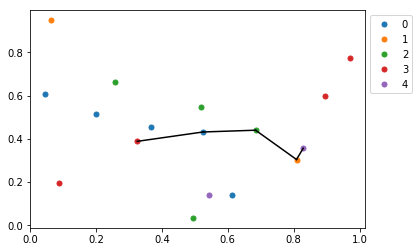

In [9]:
plot_route(X, optimal_path_in_points_idxs, set_to_points_dict)

In [ ]:
set_to_points_dict = {0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7]}
dist_mat = np.array([[  0, 345, 850, 650, 457, 833, 101, 659],
       [345,   0, 812, 766, 456, 739, 260, 718],
       [850, 812,   0, 366, 396, 140, 874, 257],
       [650, 766, 366,   0, 327, 460, 712, 121],
       [457, 456, 396, 327,   0, 381, 478, 261],
       [833, 739, 140, 460, 381,   0, 840, 340],
       [101, 260, 874, 712, 478, 840,   0, 706],
       [659, 718, 257, 121, 261, 340, 706,   0]])

In [ ]:
optimal_path_in_points, optimal_path_in_sets, optimal_cost = DP_Set_TSP(set_to_points_dict, distances_array)
print(optimal_path_in_points, optimal_path_in_sets, optimal_cost)

In [ ]:
plot_route(X, optimal_path_in_points)

In [ ]:
def plot_route_on_map()